In [34]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from skimage.feature import hog

In [35]:
# Define paths
train_folder = "../dataset/logos_train"
test_folder = "../dataset/logos_test"

# Check if dataset directories exist
if not os.path.exists(train_folder) or not os.path.exists(test_folder):
    raise FileNotFoundError("Train or test directory not found. Please verify the path.")

In [36]:
# SIFT feature extractor
sift = cv2.SIFT_create()

# Image preprocessing parameters
image_size = (256, 256)  # Resize images
batch_size = 64  # Number of images processed per batch

# Function to extract SIFT and HOG features
def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, image_size)  # Resize image
    
    # Extract SIFT features
    keypoints_sift, descriptors_sift = sift.detectAndCompute(image, None)
    
    # Extract HOG features
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    
    # Ensure descriptors are valid before concatenation
    if descriptors_sift is not None and descriptors_sift.shape[0] > 0:
        sift_features = np.mean(descriptors_sift, axis=0)
    else:
        sift_features = np.zeros(128)  # Default to zero if no SIFT features
    
    return np.concatenate((sift_features, hog_features))

In [37]:
# Function to process images in batches
def process_images_in_batches(image_paths):
    features = []
    valid_paths = []
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        for img_path in batch:
            feature_vector = extract_features(img_path)
            if feature_vector is not None:
                features.append(feature_vector)
                valid_paths.append(img_path)
    return valid_paths, np.array(features, dtype=np.float32) if features else (valid_paths, np.array([]))

# Collecting descriptors for training images
train_images = [os.path.join(train_folder, img) for img in os.listdir(train_folder)]
valid_train_images, X_train = process_images_in_batches(train_images)
if X_train.size == 0:
    raise ValueError("No valid features extracted from training images.")

In [38]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=20, metric='euclidean', metric_params={}, algorithm='brute', leaf_size=30, n_jobs=-1, p=2)
train_labels = dbscan.fit_predict(X_train)

# Compute Silhouette Score
silhouette_avg = silhouette_score(X_train, train_labels) if len(set(train_labels)) > 1 else -1

# Collecting descriptors for test images
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder)]
valid_test_images, X_test = process_images_in_batches(test_images)
if X_test.size == 0:
    raise ValueError("No valid features extracted from test images.")

# Predict clusters for test images
test_labels = dbscan.fit_predict(X_test)

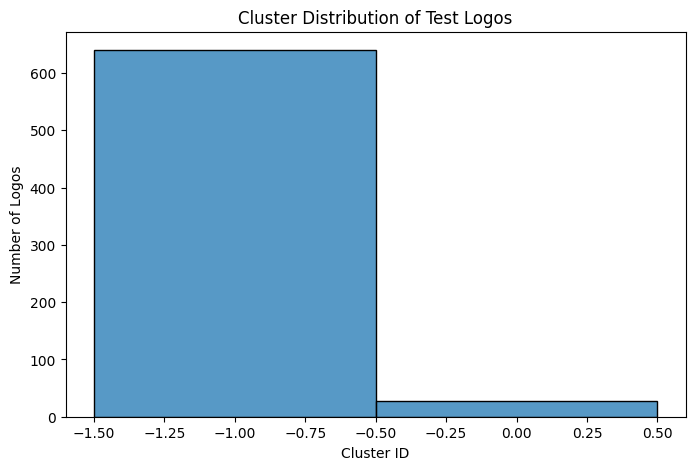

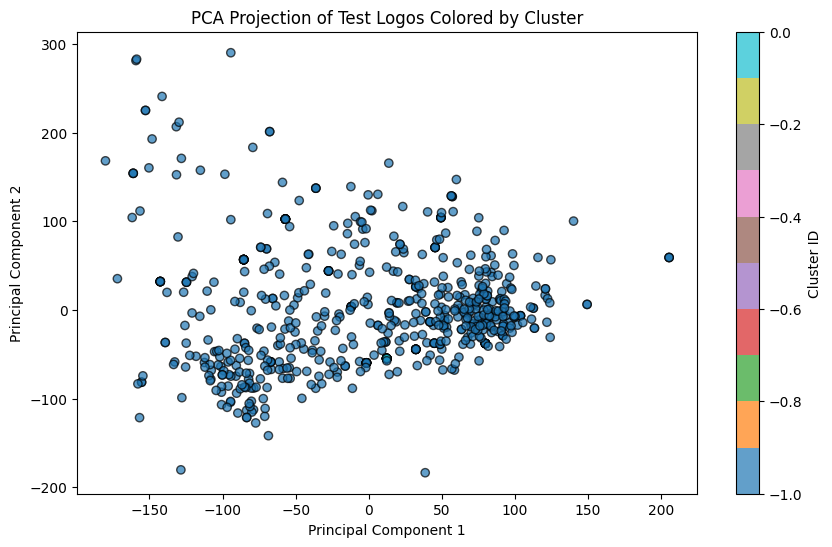

Silhouette Score: -0.17994298040866852
Number of clusters found by DBSCAN: 8


In [ ]:

# Cluster Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(test_labels, bins=len(set(test_labels)), kde=False, discrete=True)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Logos")
plt.title("Cluster Distribution of Test Logos")
plt.show()

# PCA Projection for 2D visualization on test set
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap="tab10", alpha=0.7, edgecolors="k")
plt.colorbar(label="Cluster ID")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Test Logos Colored by Cluster")
plt.show()

# Print silhouette score
print(f"Silhouette Score: {silhouette_avg}")

# Count the number of clusters (excluding noise points labeled as -1)
num_clusters = len(set(train_labels)) - (1 if -1 in train_labels else 0)
